In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Assuming the data is in a CSV file
df = pd.read_csv('stock_price_data.csv')

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Get basic statistics
print(df.describe())


            Unnamed: 0  Adj Close     Close      High       Low      Open  \
Date                                                                        
1980-03-17           0   2.296798  3.291227  3.344743  3.291227  0.000000   
1980-03-18           1   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-19           2   2.306134  3.304606  3.304606  3.304606  3.304606   
1980-03-20           3   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-21           4   2.362154  3.384880  3.438396  3.384880  0.000000   

             Volume  
Date                 
1980-03-17  41109.0  
1980-03-18   9343.0  
1980-03-19      0.0  
1980-03-20  10277.0  
1980-03-21   8409.0  
Unnamed: 0      0
Adj Close      93
Close         117
High           95
Low           127
Open          103
Volume        145
dtype: int64
         Unnamed: 0     Adj Close         Close          High           Low  \
count  11291.000000  11198.000000  11174.000000  11196.000000  11164.000000   
mean    5

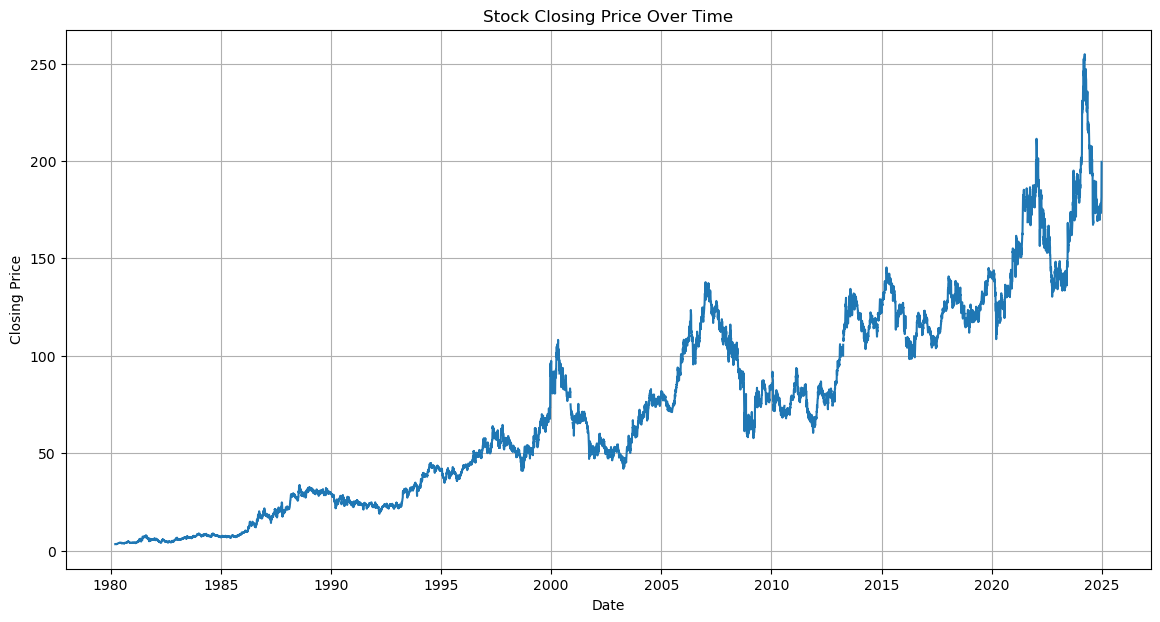

In [3]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.savefig('closing_price_trend.png')
plt.show()


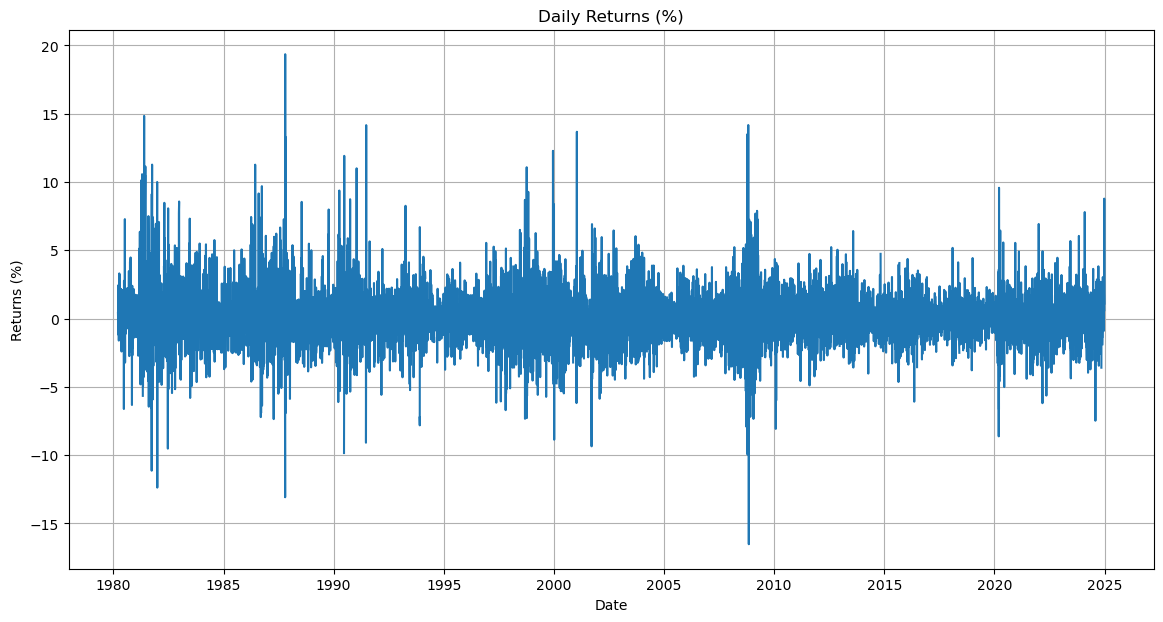

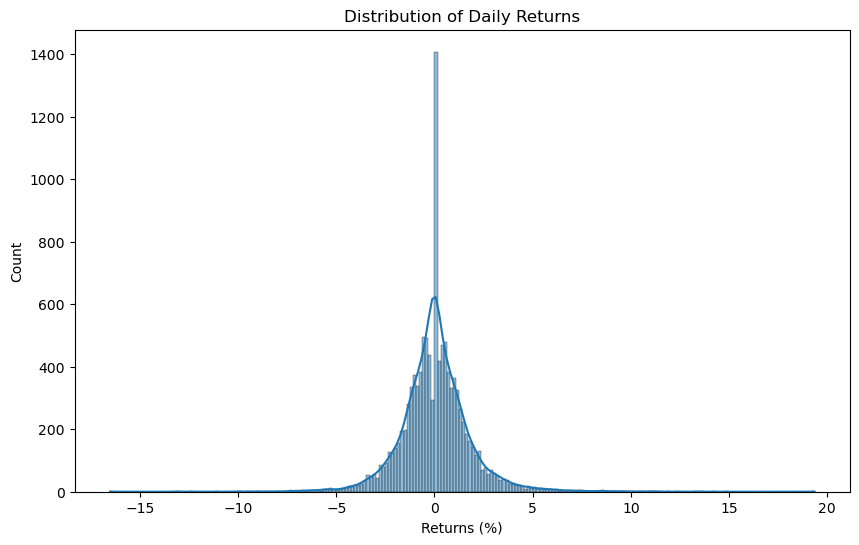

In [4]:
# Calculate daily returns
df['Returns'] = df['Close'].pct_change() * 100

plt.figure(figsize=(14, 7))
plt.plot(df['Returns'])
plt.title('Daily Returns (%)')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.grid(True)
plt.savefig('daily_returns.png')
plt.show()

# Distribution of returns
plt.figure(figsize=(10, 6))
sns.histplot(df['Returns'].dropna(), kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Returns (%)')
plt.savefig('returns_distribution.png')
plt.show()


ADF Statistic: -0.4512452679246748
p-value: 0.9011846817672275
Critical Values: {'1%': -3.4309359885764117, '5%': -2.8617989750621824, '10%': -2.566907847308494}


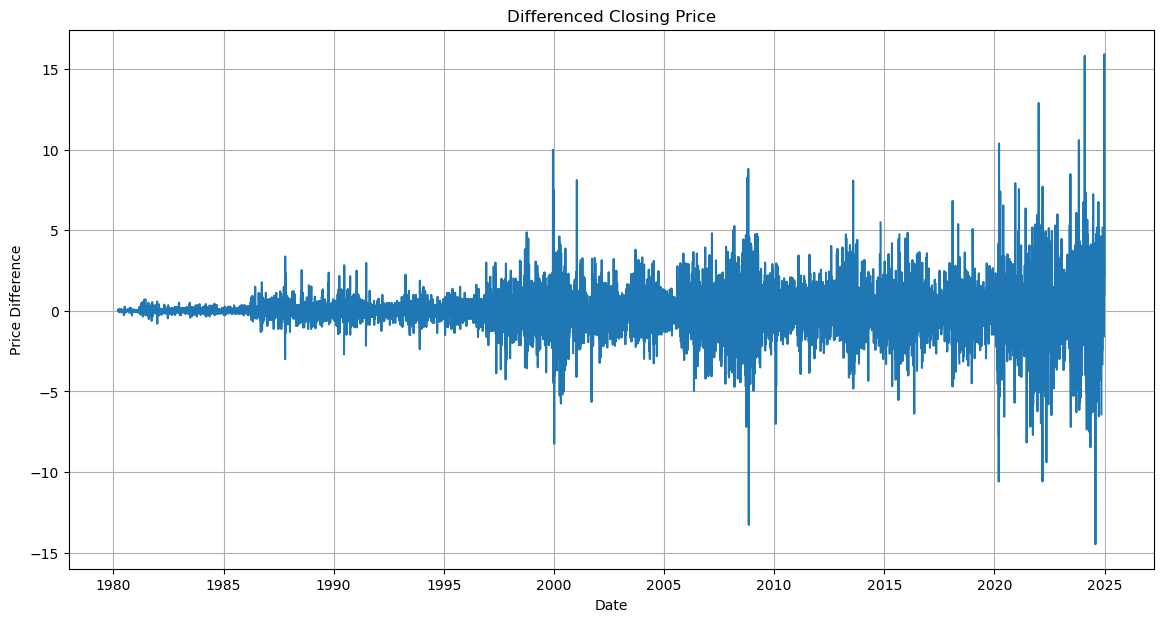

In [5]:
# Perform Augmented Dickey-Fuller test
result = adfuller(df['Close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# If p-value > 0.05, the series is non-stationary
# Try differencing if needed
df['Close_diff'] = df['Close'].diff()

plt.figure(figsize=(14, 7))
plt.plot(df['Close_diff'].dropna())
plt.title('Differenced Closing Price')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.grid(True)
plt.savefig('differenced_price.png')
plt.show()


<Figure size 1200x600 with 0 Axes>

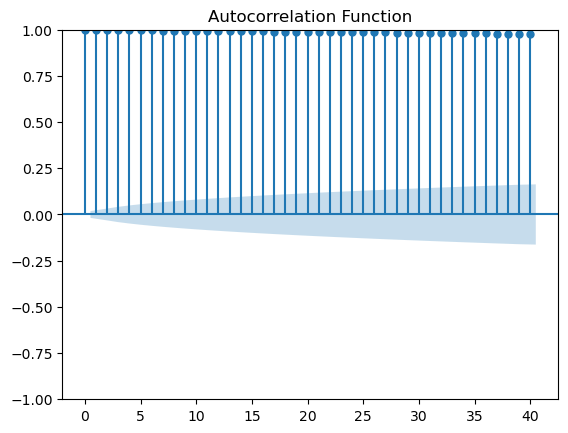

<Figure size 1200x600 with 0 Axes>

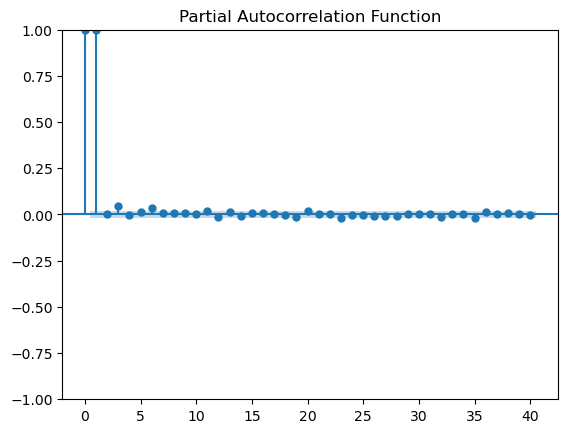

In [6]:
plt.figure(figsize=(12, 6))
plot_acf(df['Close'].dropna(), lags=40)
plt.title('Autocorrelation Function')
plt.savefig('acf_plot.png')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Close'].dropna(), lags=40)
plt.title('Partial Autocorrelation Function')
plt.savefig('pacf_plot.png')
plt.show()


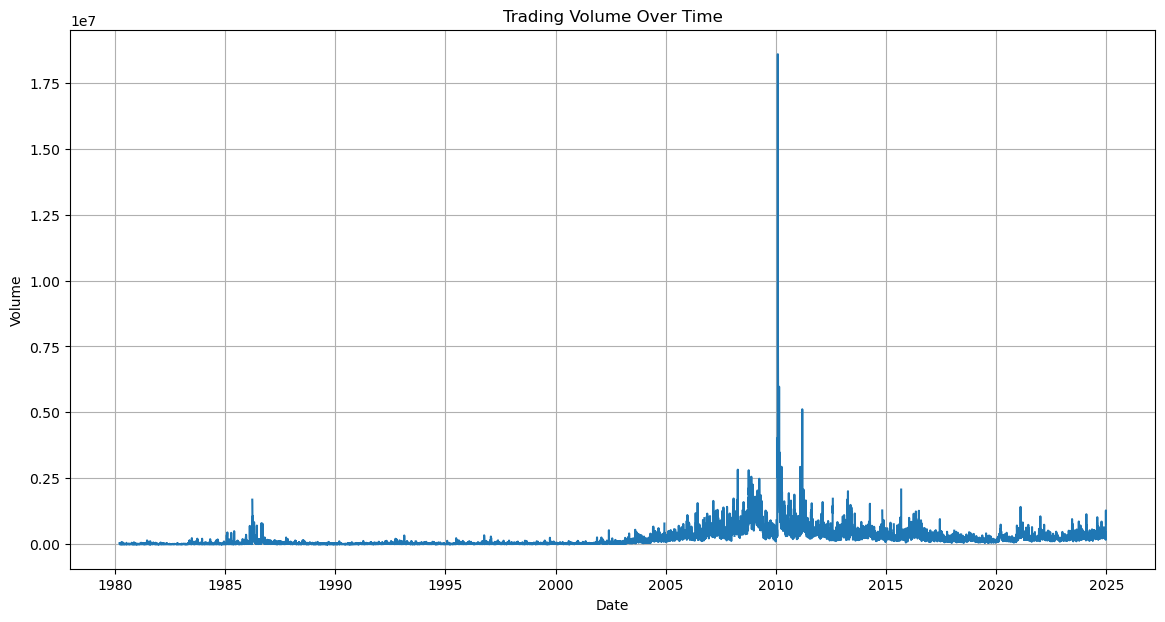

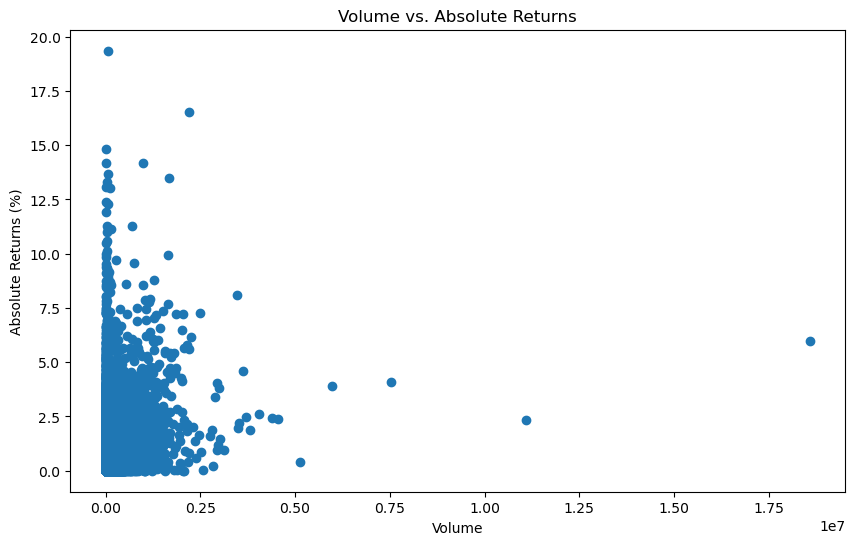

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(df['Volume'])
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.savefig('volume_trend.png')
plt.show()

# Scatter plot of volume vs. absolute returns
plt.figure(figsize=(10, 6))
plt.scatter(df['Volume'], abs(df['Returns']))
plt.title('Volume vs. Absolute Returns')
plt.xlabel('Volume')
plt.ylabel('Absolute Returns (%)')
plt.savefig('volume_vs_returns.png')
plt.show()


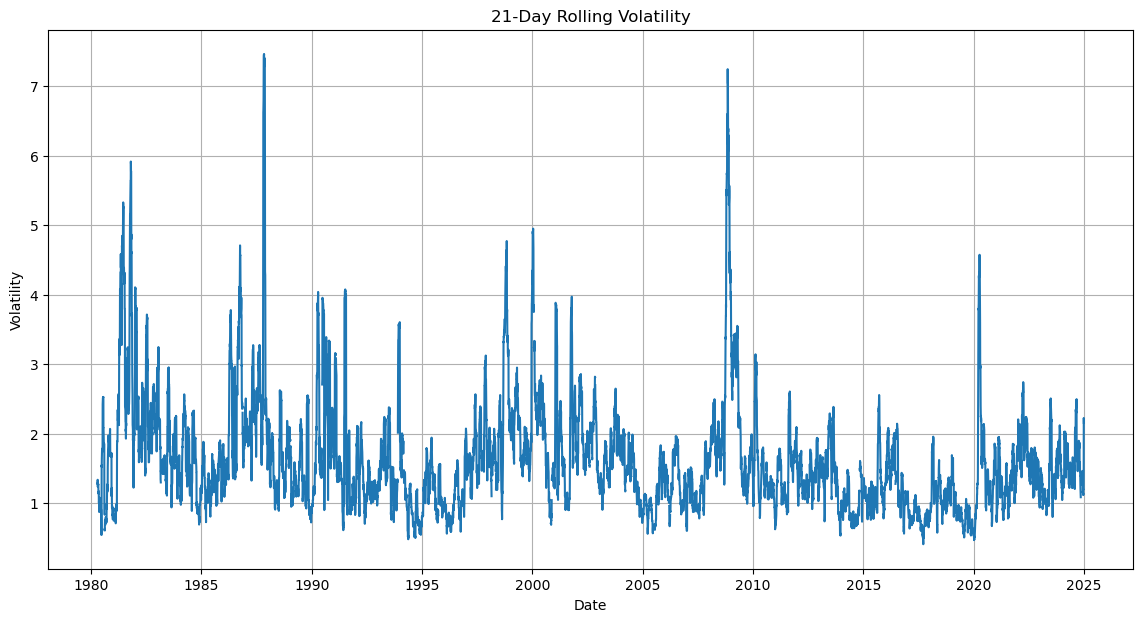

In [8]:
# Calculate rolling standard deviation (volatility)
df['Volatility'] = df['Returns'].rolling(window=21).std()

plt.figure(figsize=(14, 7))
plt.plot(df['Volatility'])
plt.title('21-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.savefig('volatility_trend.png')
plt.show()


In [9]:
# Moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Close'])

# Bollinger Bands
df['BB_middle'] = df['Close'].rolling(window=20).mean()
df['BB_std'] = df['Close'].rolling(window=20).std()
df['BB_upper'] = df['BB_middle'] + 2 * df['BB_std']
df['BB_lower'] = df['BB_middle'] - 2 * df['BB_std']

# MACD
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Price momentum
df['Price_change_1d'] = df['Close'].pct_change(periods=1)
df['Price_change_5d'] = df['Close'].pct_change(periods=5)
df['Price_change_10d'] = df['Close'].pct_change(periods=10)

# Lagged features
for i in range(1, 6):
    df[f'Close_lag_{i}'] = df['Close'].shift(i)
    df[f'Returns_lag_{i}'] = df['Returns'].shift(i)

# Temporal features
df['Day_of_week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter

# Display the engineered features
print(df.head(10))


            Unnamed: 0  Adj Close     Close      High       Low      Open  \
Date                                                                        
1980-03-17           0   2.296798  3.291227  3.344743  3.291227  0.000000   
1980-03-18           1   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-19           2   2.306134  3.304606  3.304606  3.304606  3.304606   
1980-03-20           3   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-21           4   2.362154  3.384880  3.438396  3.384880  0.000000   
1980-03-24           5   2.371490  3.398259  3.451775  3.398259  0.000000   
1980-03-25           6   2.352816  3.371501  3.425017  3.371501  0.000000   
1980-03-26           7   2.352816  3.371501  3.425017  3.371501  0.000000   
1980-03-27           8   2.324807  3.331364  3.384880  3.331364  0.000000   
1980-03-28           9   2.315470  3.317985  3.371501  3.317985  0.000000   

             Volume   Returns  Close_diff  Volatility  ...  Returns_lag_2  

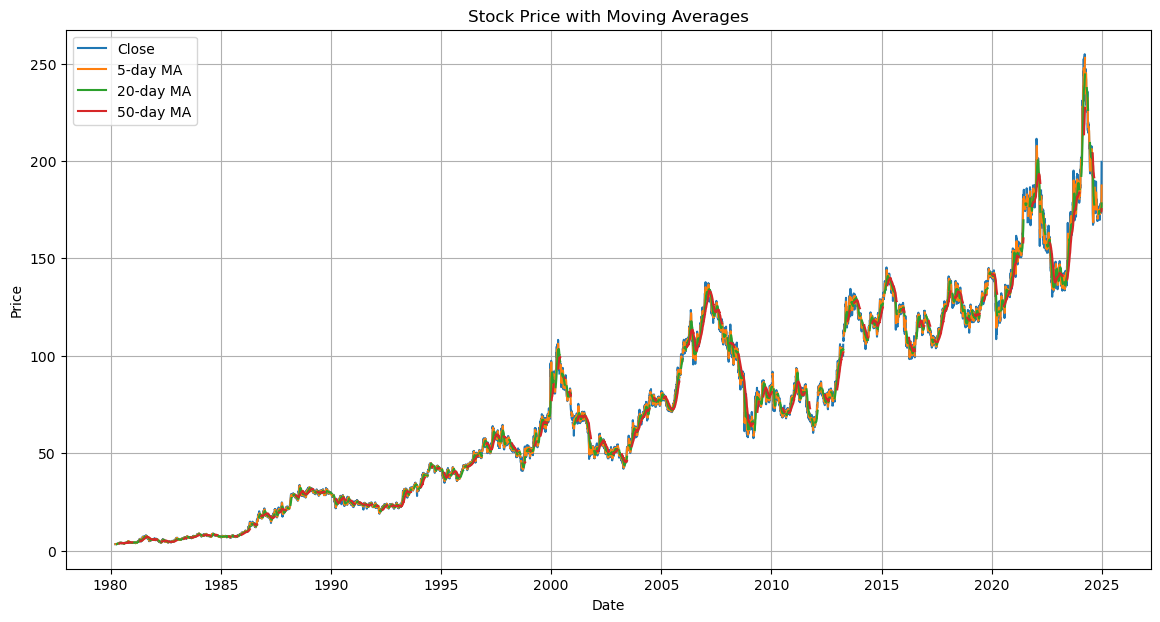

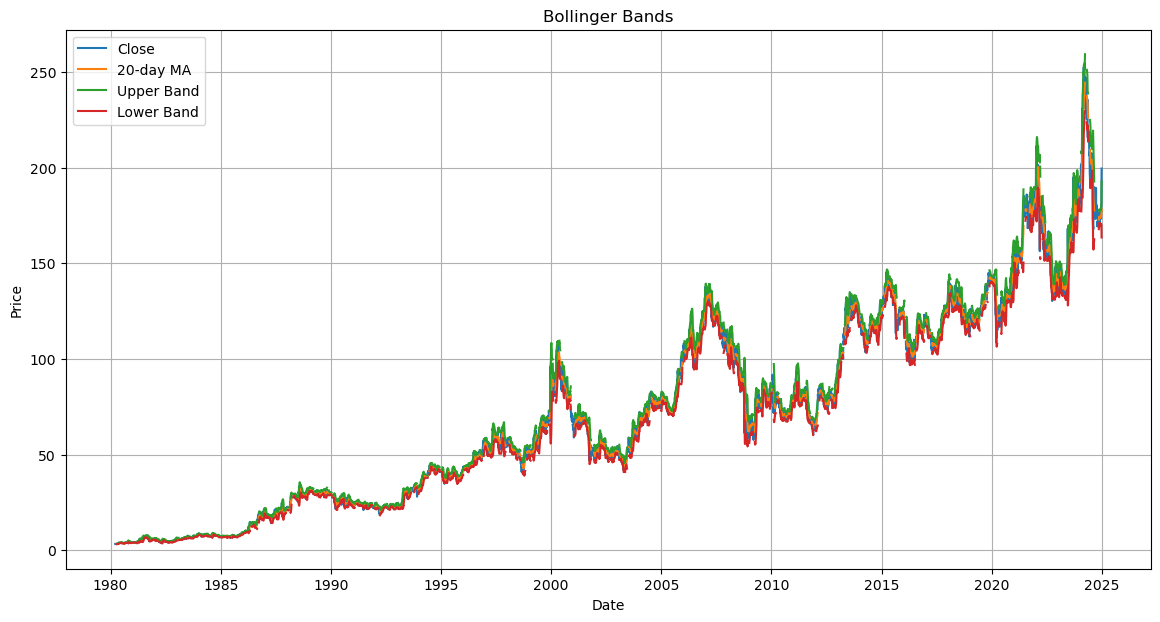

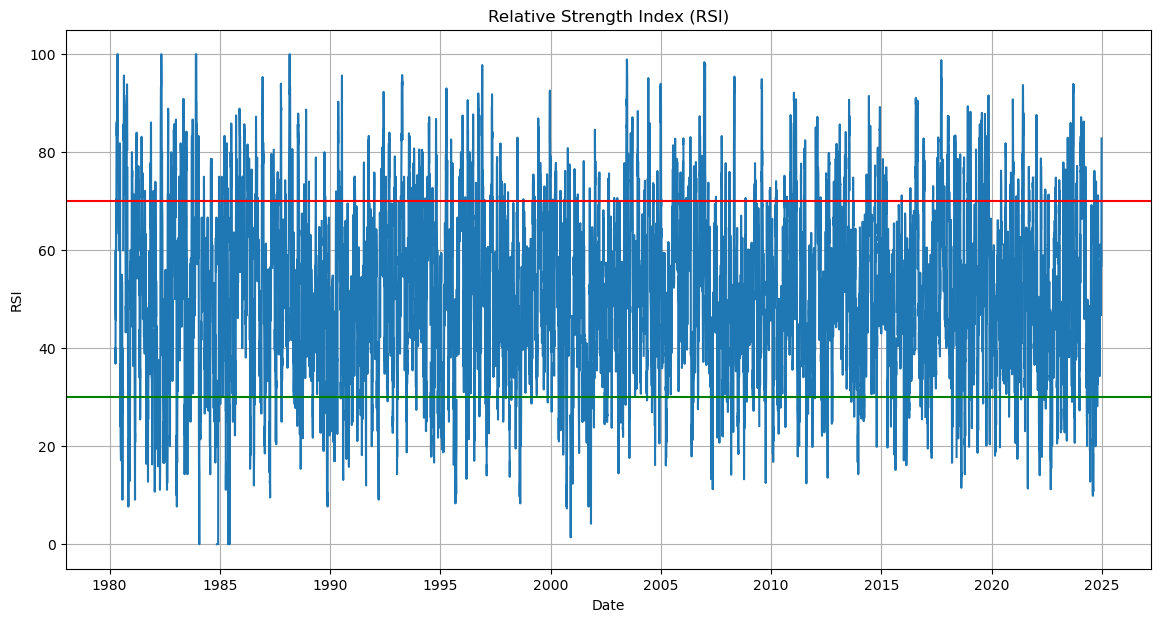

In [10]:
# Plot moving averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA5'], label='5-day MA')
plt.plot(df['MA20'], label='20-day MA')
plt.plot(df['MA50'], label='50-day MA')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('moving_averages.png')
plt.show()

# Plot Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close')
plt.plot(df['BB_middle'], label='20-day MA')
plt.plot(df['BB_upper'], label='Upper Band')
plt.plot(df['BB_lower'], label='Lower Band')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig('bollinger_bands.png')
plt.show()

# Plot RSI
plt.figure(figsize=(14, 7))
plt.plot(df['RSI'])
plt.axhline(y=70, color='r', linestyle='-')
plt.axhline(y=30, color='g', linestyle='-')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.grid(True)
plt.savefig('rsi.png')
plt.show()


In [11]:
# Create target variable - closing price 5 days into the future
df['Target'] = df['Close'].shift(-5)

# Drop rows with NaN values
df_clean = df.dropna()

# Split features and target
X = df_clean.drop(['Target'], axis=1)
y = df_clean['Target']

# Split data into training and testing sets (time-based split)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (4616, 38)
Testing set size: (1155, 38)


In [12]:
# Scale the features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit on training data
X_train_scaled = scaler_X.fit_transform(X_train)
# Reshape y for scaling
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)

# Transform test data
X_test_scaled = scaler_X.transform(X_test)
y_test_reshaped = y_test.values.reshape(-1, 1)
y_test_scaled = scaler_y.transform(y_test_reshaped)

# Convert back to 1D array for non-neural network models
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()


Linear Regression RMSE: 4.92
Linear Regression MAE: 3.53
Linear Regression Directional Accuracy: 51.60%


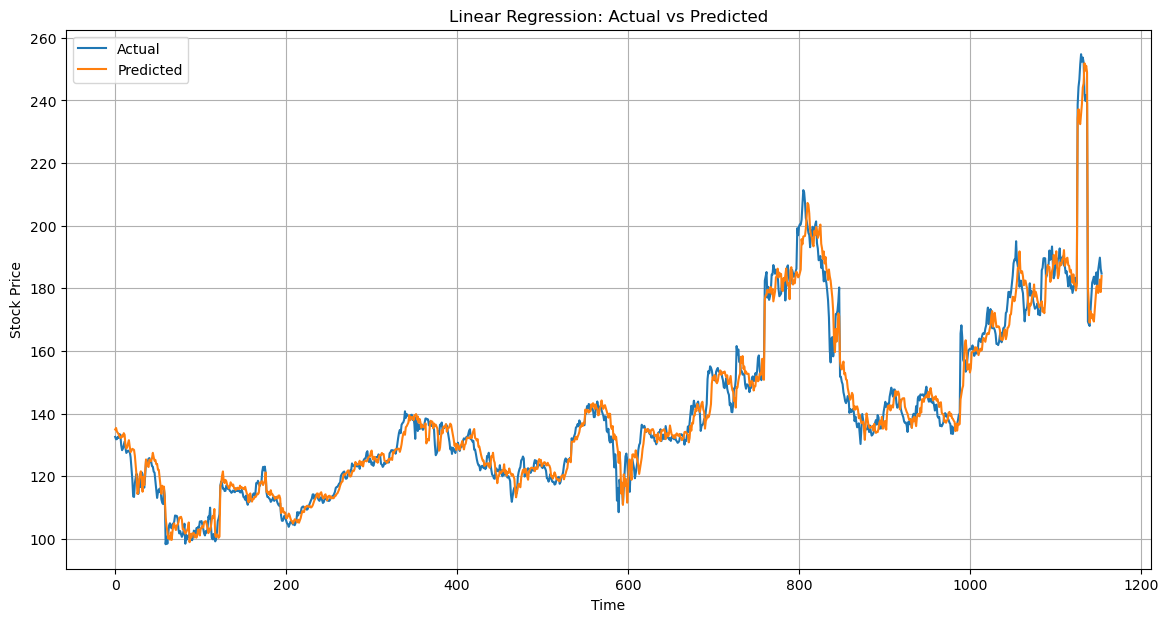

In [13]:
from sklearn.linear_model import LinearRegression

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
lr_pred_scaled = lr_model.predict(X_test_scaled)

# Inverse transform to get actual prices
lr_pred = scaler_y.inverse_transform(lr_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
lr_rmse = np.sqrt(mean_squared_error(y_test_actual, lr_pred))
lr_mae = mean_absolute_error(y_test_actual, lr_pred)

print(f"Linear Regression RMSE: {lr_rmse:.2f}")
print(f"Linear Regression MAE: {lr_mae:.2f}")

# Calculate directional accuracy
y_test_direction = np.sign(y_test_actual - X_test['Close'].values)
lr_pred_direction = np.sign(lr_pred - X_test['Close'].values)
lr_dir_accuracy = np.mean(y_test_direction == lr_pred_direction)

print(f"Linear Regression Directional Accuracy: {lr_dir_accuracy:.2%}")

# Plot predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual')
plt.plot(lr_pred, label='Predicted')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lr_predictions.png')
plt.show()


Random Forest RMSE: 22.56
Random Forest MAE: 12.76
Random Forest Directional Accuracy: 53.07%


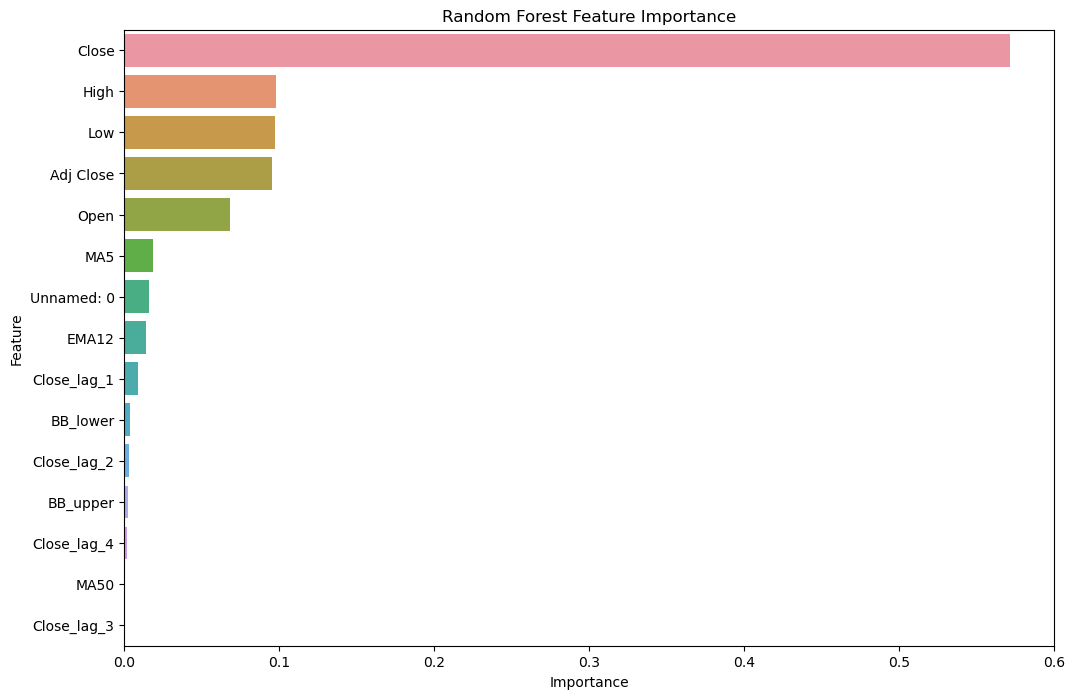

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
rf_pred_scaled = rf_model.predict(X_test_scaled)

# Inverse transform to get actual prices
rf_pred = scaler_y.inverse_transform(rf_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
rf_rmse = np.sqrt(mean_squared_error(y_test_actual, rf_pred))
rf_mae = mean_absolute_error(y_test_actual, rf_pred)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")

# Calculate directional accuracy
rf_pred_direction = np.sign(rf_pred - X_test['Close'].values)
rf_dir_accuracy = np.mean(y_test_direction == rf_pred_direction)

print(f"Random Forest Directional Accuracy: {rf_dir_accuracy:.2%}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Random Forest Feature Importance')
plt.savefig('rf_feature_importance.png')
plt.show()


In [15]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
xgb_pred_scaled = xgb_model.predict(X_test_scaled)

# Inverse transform to get actual prices
xgb_pred = scaler_y.inverse_transform(xgb_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test_actual, xgb_pred))
xgb_mae = mean_absolute_error(y_test_actual, xgb_pred)

print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")

# Calculate directional accuracy
xgb_pred_direction = np.sign(xgb_pred - X_test['Close'].values)
xgb_dir_accuracy = np.mean(y_test_direction == xgb_pred_direction)

print(f"XGBoost Directional Accuracy: {xgb_dir_accuracy:.2%}")


XGBoost RMSE: 23.21
XGBoost MAE: 12.95
XGBoost Directional Accuracy: 53.68%


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0381 - val_loss: 7.5666e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - val_loss: 9.3484e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 9.9855e-04
Epoch 11/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 12/50
116/116 ━━━━━━━━━━━━━━━━━━━━

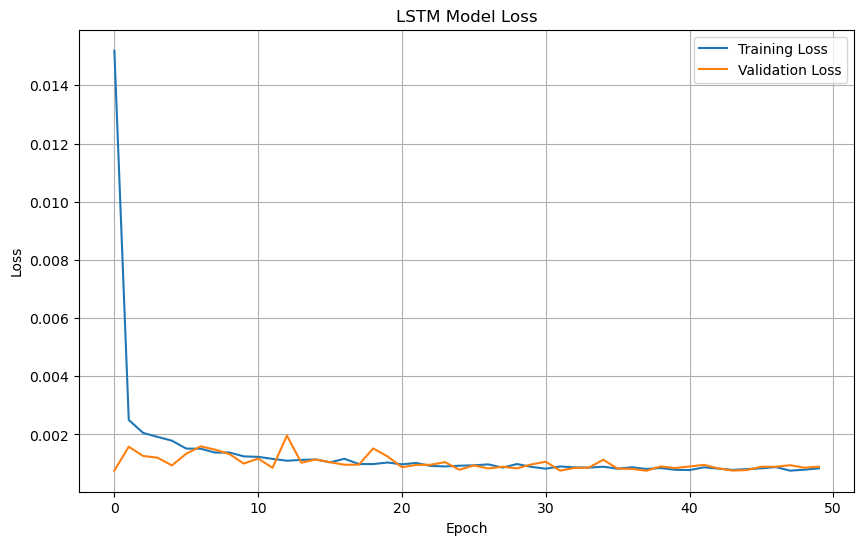

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


NameError: name 'lstm_rmse' is not defined

In [16]:
# Reshape data for LSTM [samples, time steps, features]
# For simplicity, we'll use all features and a single time step
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

# Compile model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
lstm_history = lstm_model.fit(
    X_train_lstm, 
    y_train_scaled, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('lstm_training.png')
plt.show()

# Make predictions
lstm_pred_scaled = lstm_model.predict(X_test_lstm).flatten()

# Inverse transform to get actual prices
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
lstm_rmse


In [17]:
# Assuming you've already trained your best model (e.g., XGBoost)
# and have made predictions on the test set

# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'Date': X_test.index,
    'Actual_Close': y_test_actual,
    'Predicted_Close': xgb_pred,  # or whichever model you chose as best
    'Prediction_Error': y_test_actual - xgb_pred,
    'Direction_Actual': np.sign(y_test_actual - X_test['Close'].values),
    'Direction_Predicted': np.sign(xgb_pred - X_test['Close'].values)
})

# Add a column indicating if direction prediction was correct
predictions_df['Direction_Correct'] = (
    predictions_df['Direction_Actual'] == predictions_df['Direction_Predicted']
)

# Save to CSV
predictions_df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")


Predictions saved to 'predictions.csv'


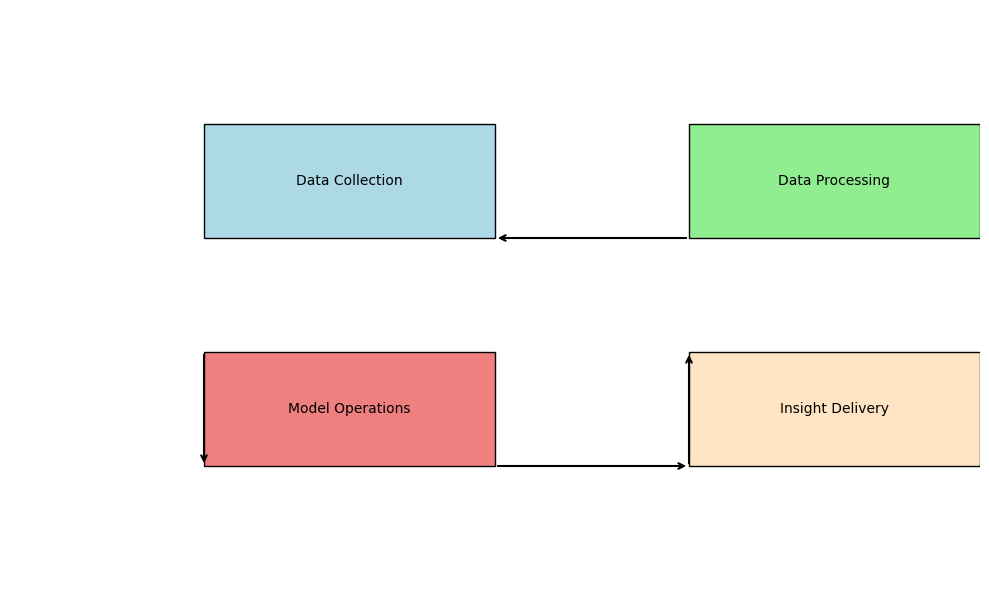

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define component boxes
components = {
    'Data Collection': {'color': 'lightblue', 'position': (0.2, 0.6)},
    'Data Processing': {'color': 'lightgreen', 'position': (0.7, 0.6)},
    'Model Operations': {'color': 'lightcoral', 'position': (0.2, 0.2)},
    'Insight Delivery': {'color': 'bisque', 'position': (0.7, 0.2)}
}

# Create rectangles for each component
for name, props in components.items():
    rect = patches.Rectangle(props['position'], 0.3, 0.2, 
                            linewidth=1, edgecolor='black', 
                            facecolor=props['color'])
    ax.add_patch(rect)
    ax.text(props['position'][0] + 0.15, props['position'][1] + 0.1, 
            name, ha='center', va='center')

# Add arrows between components
arrows = [
    ((0.5, 0.6), (0.7, 0.6)),  # Data Collection to Data Processing
    ((0.7, 0.4), (0.7, 0.2)),  # Data Processing to Insight Delivery
    ((0.7, 0.2), (0.5, 0.2)),  # Insight Delivery to Model Operations
    ((0.2, 0.2), (0.2, 0.4)),  # Model Operations to Data Collection
]

for start, end in arrows:
    ax.annotate("", xy=end, xytext=start,
                arrowprops=dict(arrowstyle="<-", lw=1.5))

# Remove axis ticks and labels
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Save the figure
plt.tight_layout()
plt.savefig('system_architecture.png', dpi=300, bbox_inches='tight')
plt.show()


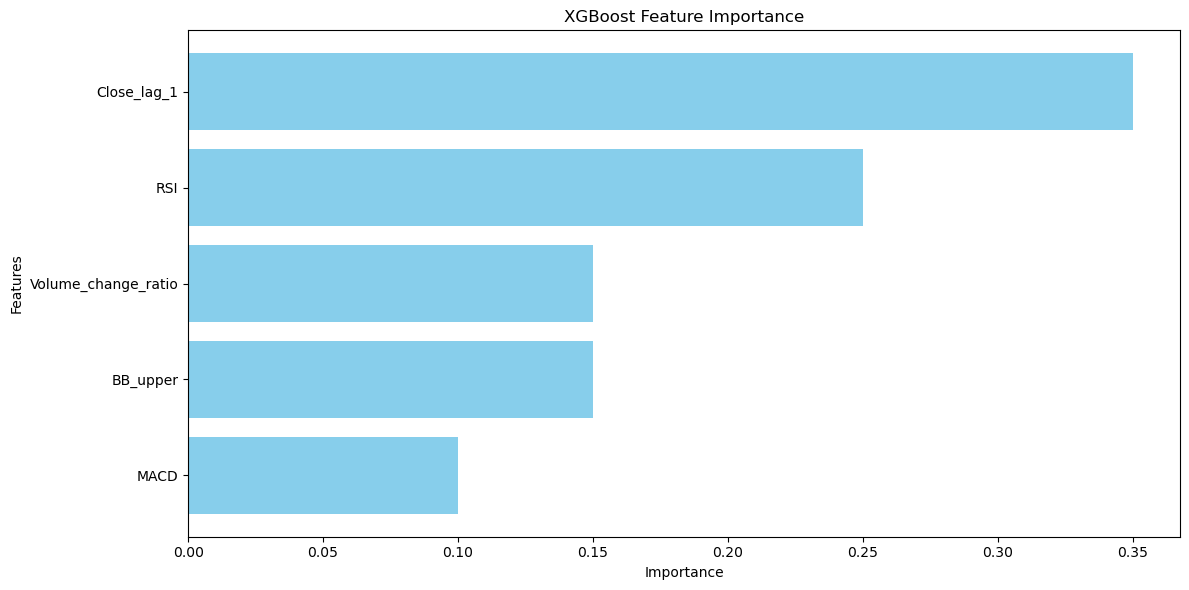

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample feature importance data (replace with your actual data)
features = ['Close_lag_1', 'RSI', 'BB_upper', 'Volume_change_ratio', 'MACD']
importance = [0.35, 0.25, 0.15, 0.15, 0.10]  # Importance values

# Create DataFrame
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=True)

# Create horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


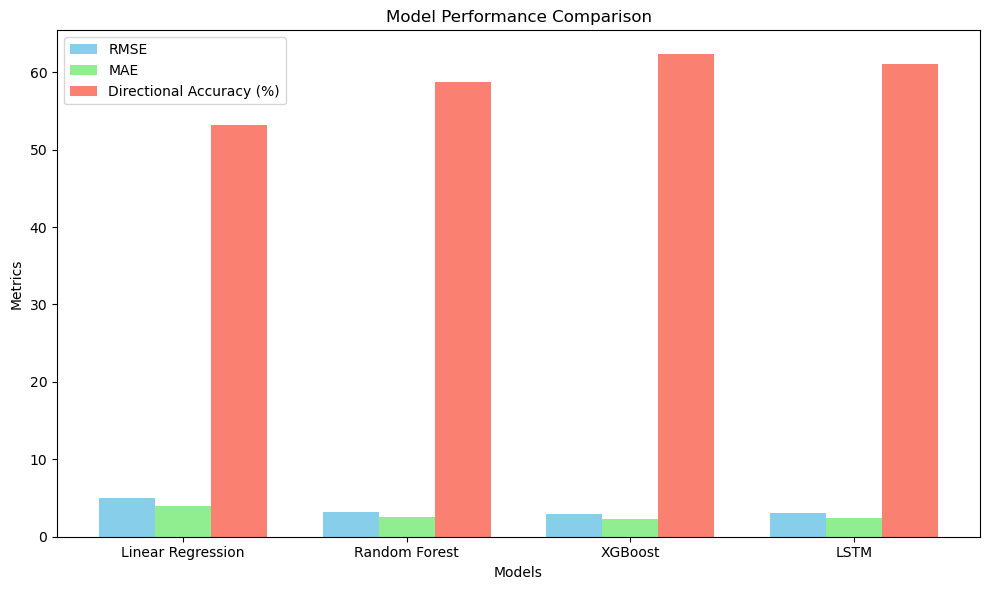

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual results)
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'LSTM']
rmse = [5.0, 3.2, 2.9, 3.0]
mae = [4.0, 2.6, 2.3, 2.4]
directional_accuracy = [53.2, 58.7, 62.3, 61.1]  # In percentage

# Set width of bars
barWidth = 0.25
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, rmse, width=barWidth, color='skyblue', label='RMSE')
plt.bar(r2, mae, width=barWidth, color='lightgreen', label='MAE')
plt.bar(r3, directional_accuracy, width=barWidth, color='salmon', label='Directional Accuracy (%)')

# Add labels and legend
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Performance Comparison')
plt.xticks([r + barWidth for r in range(len(models))], models)
plt.legend()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
